In [15]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import random
import matplotlib.pyplot as plt
from skimage.util import random_noise
from tensorflow.keras.layers import Layer, Conv2D, Add, ReLU, Concatenate, GlobalAveragePooling2D, Multiply, Input, Lambda,  MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from keras.models import load_model
from tensorflow.keras.saving import register_keras_serializable


In [16]:

def preprocess(sample, img_size):
    """Preprocessa le immagini: ridimensionamento e normalizzazione."""
    image = tf.image.resize(sample['image'], img_size) / 255.0  # Normalizza in [0,1]
    label = sample['label']  # Estrai l'etichetta
    return image, label

def load_dataset(split='train', img_size=(256,256), batch_size=16):
    """
    Carica il dataset Oxford-IIIT Pet da tfds e applica il preprocessamento.
    Ritorna un dataset in batch.
    """
    ds_split = 'train[:80%]'
    if(split == 'validation'):
      ds_split = 'train[80%:]'
    elif(split != 'train' or split != 'validation'):
      ds_split = 'test'

    dataset = tfds.load('oxford_iiit_pet', split=ds_split, as_supervised=False)  # as_supervised=False per mantenere dict
    dataset = dataset.map(lambda sample: preprocess(sample, img_size))  # Preprocessing
    dataset = dataset.shuffle(1024).batch(batch_size).prefetch(tf.data.AUTOTUNE)  # Ottimizza il caricamento
    return dataset



In [17]:
# Parametri
img_size = (112, 112)
batch_size = 16
noise_factor = 0.4
epochs = 50

# Caricamento dataset
train_ds = load_dataset( split='train',      img_size=img_size,  )
valid_ds = load_dataset( split='validation', img_size=img_size   )
test_ds  = load_dataset( split='test',       img_size=img_size,  )

In [18]:
def add_noise(x, noise_factor=0.1):
    noise = tf.random.normal(shape=tf.shape(x), mean=0.0, stddev=1.0)
    x_noisy = x + noise_factor * noise
    return x_noisy

In [19]:
train_ds_noisy = train_ds.map(lambda x, label: (add_noise(x, noise_factor), x))
valid_ds_noisy = train_ds.map(lambda x, label: (add_noise(x, noise_factor), x))

In [20]:
def plot_side_by_side(x_noisy, x_original, n=10):
    """
    Visualizza n coppie di immagini affiancando l'immagine rumorosa e quella originale per immagini a colori.
    """
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Immagine rumorosa
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_noisy[i])
        plt.title("Rumorosa")
        plt.axis('off')

        # Immagine originale
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(x_original[i])
        plt.title("Originale")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

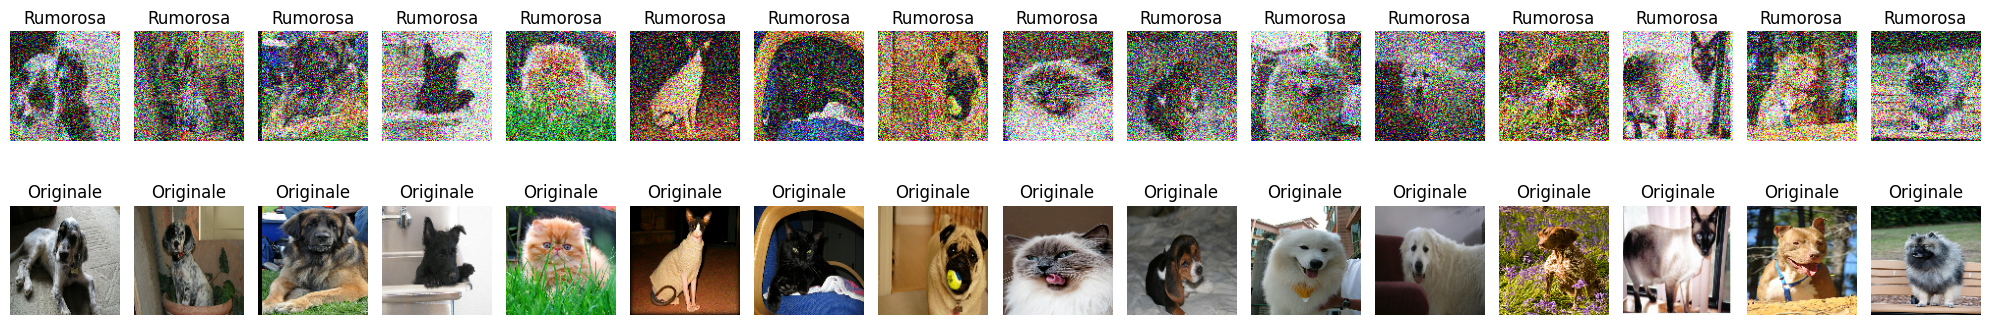

In [21]:
# Prendi un batch dal dataset (ad esempio, il primo batch)
batch = next(iter(test_ds_noisy))
x_noisy_batch, x_original_batch = batch

# Converti i tensori in array NumPy
x_noisy_np = x_noisy_batch.numpy()
x_original_np = x_original_batch.numpy()

# Usa la funzione plot_side_by_side per visualizzare n immagini
plot_side_by_side(x_noisy_np, x_original_np, n=batch_size)


Creazione modello

In [22]:
def plot_denoising_results(x_test_noisy, decoded_imgs, x_test, n=10):
    """
    Visualizza n immagini rumorose, le rispettive immagini denoised e quelle originali.
    """
    plt.figure(figsize=(20, 4))
    n = 10
    for i in range(n):
        # Immagine rumorosa
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(x_test_noisy[i])
        plt.title("Rumorosa")
        plt.axis('off')
        # Immagine denoised
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(decoded_imgs[i])
        plt.title("Denoised")
        plt.axis('off')
        # Immagine originale
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(x_test[i])
        plt.title("Originale")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


In [23]:
def psnr(original, denoised):
  mse = np.mean((original - denoised) ** 2)
  if mse == 0:
    return float('inf') # immagini identiche
  max_pixel = 1.0 # valore massimo per immagini normalizzate in [0, 1]
  return 10 * np.log10((max_pixel ** 2) / mse)

In [24]:
def build_autoencoder(input_shape):
    """
    Costruisce un autoencoder convoluzionale per immagini a colori.
    Parametri:
      input_shape: forma dell'immagine in input (es. (32,32,3))
    Ritorna:
      autoencoder: modello compilato
    """
    input_img = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, (3,3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2,2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3,3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    decoded = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return autoencoder

def train_autoencoder(autoencoder, x_train_noisy, x_train, x_test_noisy, x_test, epochs=50, batch_size=128):
    """
    Addestra l'autoencoder utilizzando le immagini rumorose come input e quelle originali come target.
    """
    history = autoencoder.fit(x_train_noisy, x_train,
                              epochs=epochs,
                              batch_size=batch_size,
                              shuffle=True,
                              validation_data=(x_test_noisy, x_test))
    return history

In [25]:
autoencoder = build_autoencoder(input_shape=(img_size[0], img_size[1], 3))
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 112, 112, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 112, 112, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 3)    │         1,731 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,307 (446.51 KB)

 Trainable params: 114,307 (446.51 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history = autoencoder.fit(train_ds_noisy,
                validation_data=valid_ds_noisy,
                batch_size=16,
                epochs=50)

Epoch 1/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 31s 97ms/step - accuracy: 0.5688 - loss: 0.5680 - val_accuracy: 0.7254 - val_loss: 0.5399
Epoch 2/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 22s 83ms/step - accuracy: 0.7109 - loss: 0.5386 - val_accuracy: 0.6965 - val_loss: 0.5382
Epoch 3/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.7150 - loss: 0.5380 - val_accuracy: 0.7223 - val_loss: 0.5369
Epoch 4/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.7223 - loss: 0.5371 - val_accuracy: 0.7274 - val_loss: 0.5359
Epoch 5/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 81ms/step - accuracy: 0.7263 - loss: 0.5358 - val_accuracy: 0.7319 - val_loss: 0.5352
Epoch 6/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 42s 87ms/step - accuracy: 0.7271 - loss: 0.5357 - val_accuracy: 0.7319 - val_loss: 0.5351
Epoch 7/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 40s 82ms/step - accuracy: 0.7288 - loss: 0.5347 - val_accuracy: 0.7203 - val_loss: 0.5351
Epoch 8/50
230/230 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.7242 - loss: 0.5351 - 

In [ ]:
test_ds_noisy  = add_noise(test_ds, noise_factor)

In [29]:
decoded_imgs = autoencoder.predict(test_ds_noisy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step


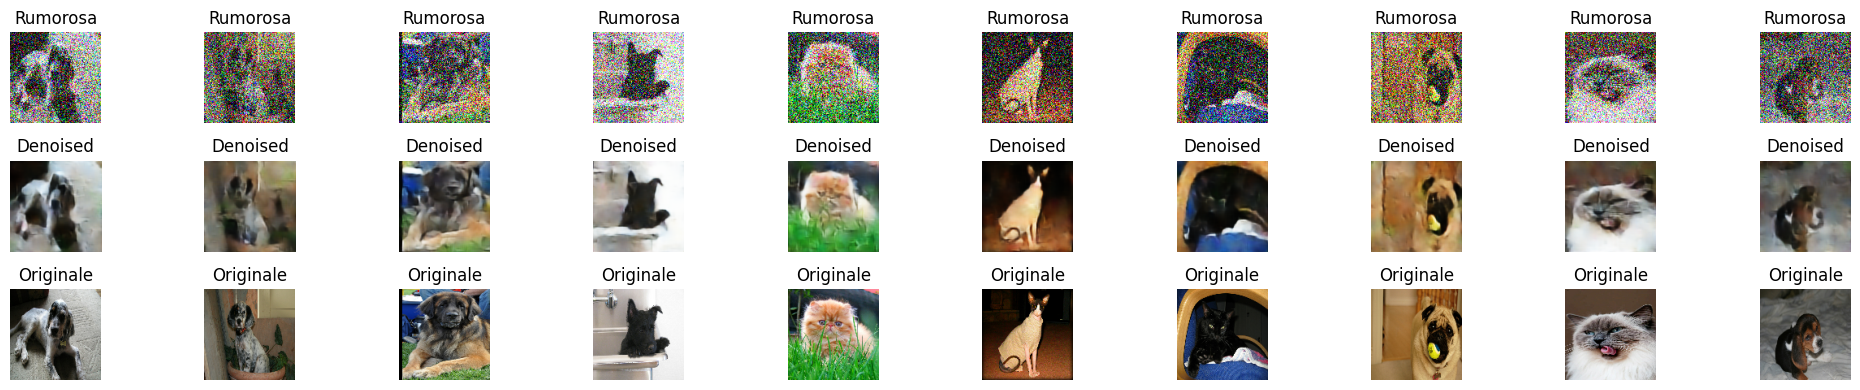

In [30]:
plot_denoising_results(test_ds_noisy, decoded_imgs, test_ds, n=10)

In [32]:
print(history.history.keys())  # mostra le chiavi disponibili


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [33]:
print(history.history['accuracy'])

[0.6428155899047852, 0.7111132740974426, 0.7182869911193848, 0.7235543131828308, 0.7252352237701416, 0.7275447249412537, 0.7275757193565369, 0.7280610203742981, 0.7290428280830383, 0.7282286286354065, 0.7307628393173218, 0.7335585951805115, 0.7335048317909241, 0.7340746521949768, 0.7317403554916382, 0.7340493202209473, 0.7323127388954163, 0.7330169677734375, 0.733648419380188, 0.7363107800483704, 0.7357128262519836, 0.7338502407073975, 0.7359168529510498, 0.7324384450912476, 0.7372792959213257, 0.738230288028717, 0.7376987338066101, 0.7373645901679993, 0.7361190319061279, 0.735636293888092, 0.7366970777511597, 0.7393516898155212, 0.737484335899353, 0.7374017834663391, 0.7391754388809204, 0.7400845289230347, 0.7390121817588806, 0.7385973930358887, 0.7413798570632935, 0.7408818006515503, 0.7401609420776367, 0.7415421605110168, 0.739395797252655, 0.740932047367096, 0.7409314513206482, 0.7415196299552917, 0.7421219348907471, 0.7430405616760254, 0.7413613796234131, 0.7424246072769165]


In [34]:
autoencoder.save('new_autoencoder.keras')

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

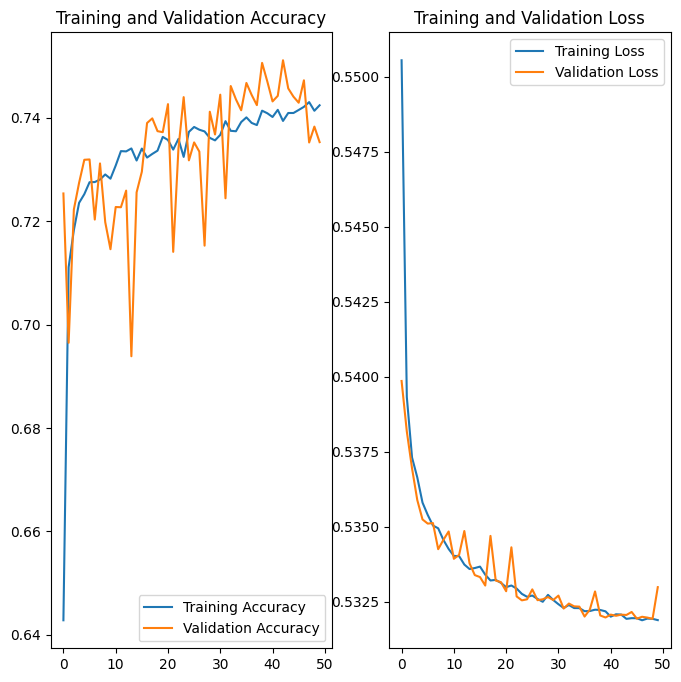

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
from skimage.metrics import peak_signal_noise_ratio as psnr

In [38]:
psnr_values = [psnr(test_ds_noisy[i], decoded_imgs[i], data_range=1.0) for i in range(len(test_ds_noisy))]


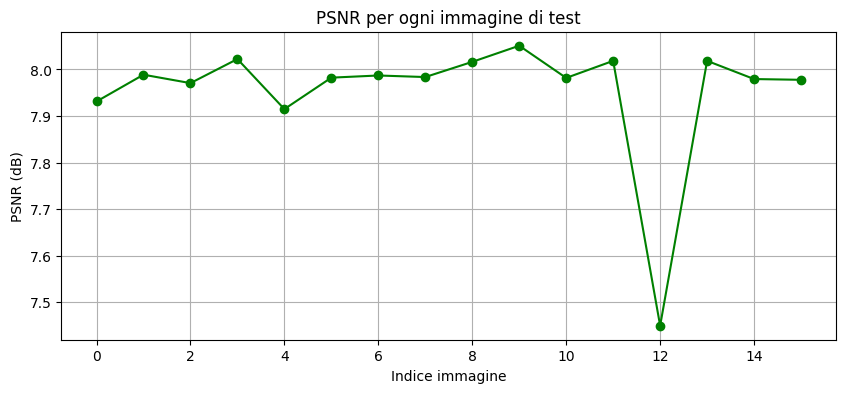

Media PSNR sul test set: 7.95 dB


In [39]:

# Plot dei PSNR per ogni immagine
plt.figure(figsize=(10, 4))
plt.plot(psnr_values, marker='o', linestyle='-', color='green')
plt.title('PSNR per ogni immagine di test')
plt.xlabel('Indice immagine')
plt.ylabel('PSNR (dB)')
plt.grid(True)
plt.show()

# (Facoltativo) Media PSNR
print(f"Media PSNR sul test set: {np.mean(psnr_values):.2f} dB")